In [237]:
import torch

import numpy as np

import torch.nn as nn 

import torch.nn.functional as F

import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split

In [238]:
# 1. Create toy dataset (moons)

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)

X = torch.tensor(X, dtype=torch.float32)

y = torch.tensor(y, dtype=torch.float32).view(-1,1)

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [240]:
# 2. Define deep network (6 layers)

class DeepNet(nn.Module):

    def __init__(self, init='xavier'):
        super().__init__()

        layers = []

        self.linears = nn.ModuleList()

        in_dim = 2

        for _ in range(6):

            out_dim = 64

            linear = nn.Linear(in_dim, out_dim)

            self.linears.append(linear)

            in_dim = out_dim

        self.out = nn.Linear(in_dim, 1)

        self.init_weights(init)

    
    def init_weights(self, init):

        for layer in self.linears:

            if init =='bad':

                nn.init.constant_(layer.weight, 1.5)

            elif init == 'xavier':

                nn.init.xavier_uniform_(layer.weight)

            elif init == 'he':

                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')

    
    def forward(self,x):

        activations = []

        for layer in self.linears:

            x = F.relu(layer(x))

            activations.append(x)

        return torch.sigmoid(self.out(x)),activations

In [241]:
# Training Function


def train_model(init_type):

    model = DeepNet(init = init_type)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    criterion = nn.BCELoss()


    losses = []

    grad_norms = []

    activation_tracker = []


    for epoch in range(100):

        optimizer.zero_grad()

        output, activations = model(X_train)

        loss = criterion(output, y_train)

        loss.backward()


        grad_norm = sum((p.grad.norm() for p in model.parameters() if p.grad is not None))

        grad_norms.append(grad_norm.item())


        activation_tracker.append([a.mean().item() for a in activations])


        optimizer.step()

        losses.append(loss.item())

    return losses, grad_norms, activation_tracker, model

In [242]:
# 4. Run Experiments

inits = ['bad', 'xavier', 'he']

results = {}




for init in inits:

    print(f'Training with {init} Initialization...')

    results[init] = train_model(init)




Training with bad Initialization...
Training with xavier Initialization...
Training with he Initialization...


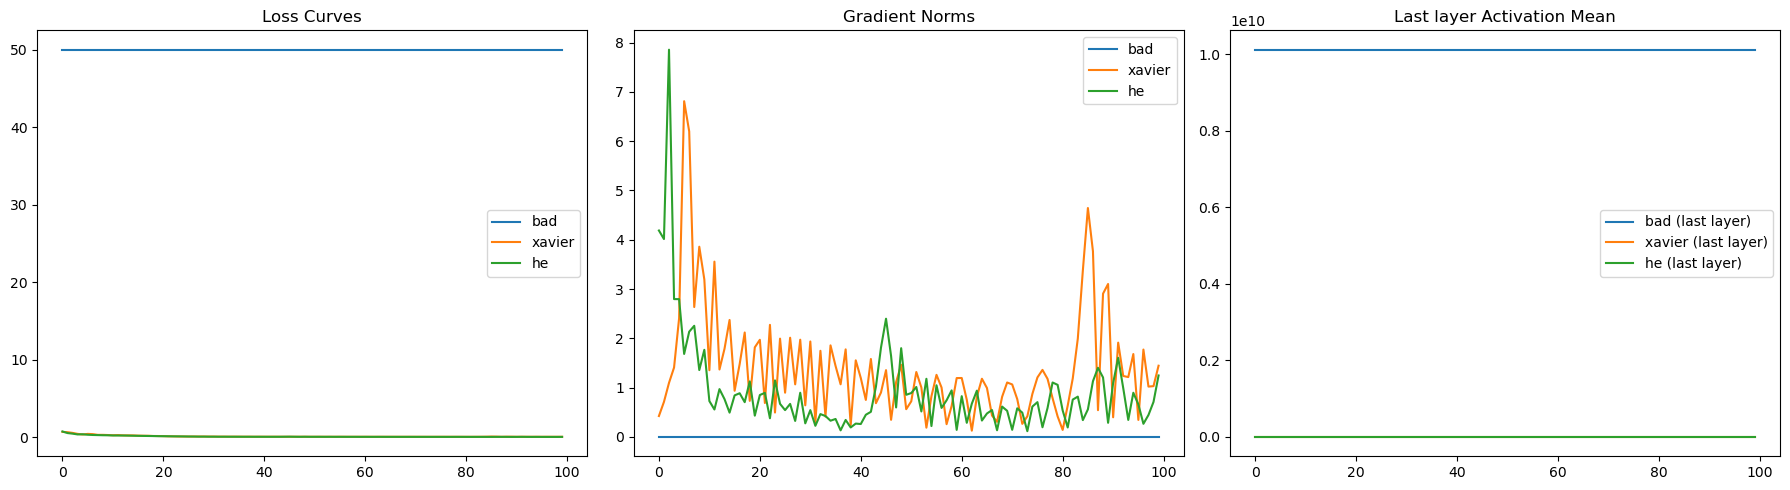

In [243]:
# 5. Plotting


fig, axes = plt.subplots(1,3, figsize=(18,5))

# Loss curve

for init in inits:

    axes[0].plot(results[init][0], label= init)

axes[0].set_title('Loss Curves')

axes[0].legend()


# Gradient norms

for init in inits:

    axes[1].plot(results[init][1], label=init)

axes[1].set_title('Gradient Norms')

axes[1].legend()

# Activation Trends

for init in inits:

    activations = np.array(results[init][2])

    axes[2].plot(activations[:,-1], label=f'{init} (last layer)')

axes[2].set_title('Last layer Activation Mean')

axes[2].legend()


plt.tight_layout()

plt.show()

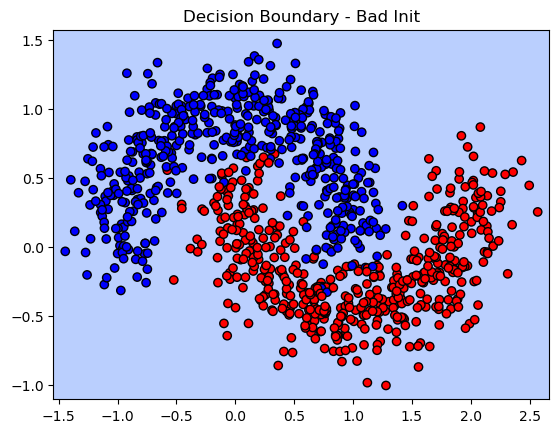

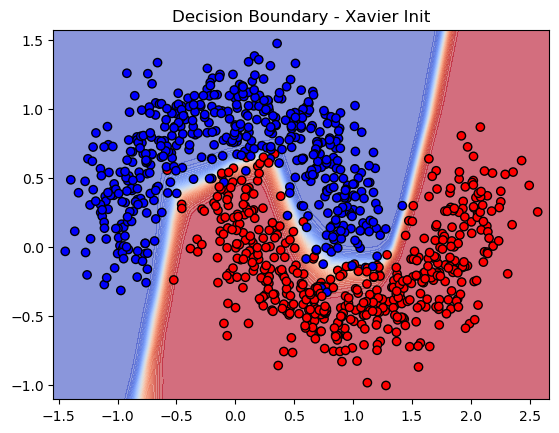

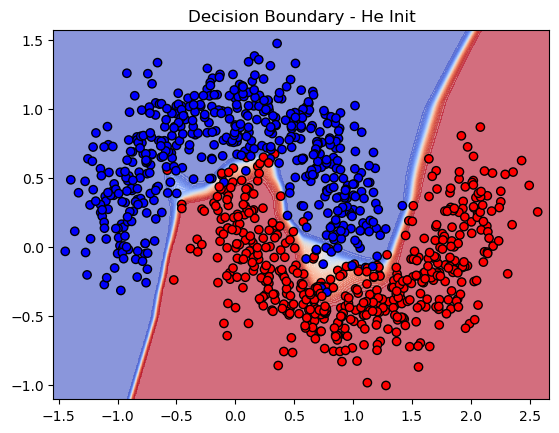

In [244]:
def plot_decision_boundary(model, X, y, title):
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        pred = model(torch.tensor(grid, dtype=torch.float32))[0].reshape(xx.shape)
    plt.contourf(xx, yy, pred, levels=50, cmap="coolwarm", alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap=ListedColormap(['blue','red']), edgecolor='k')
    plt.title(title)
    plt.show()

plot_decision_boundary(results['bad'][3], X, y, "Decision Boundary - Bad Init")

plot_decision_boundary(results['xavier'][3], X, y, "Decision Boundary - Xavier Init")

plot_decision_boundary(results['he'][3], X, y, "Decision Boundary - He Init")


